In [ ]:
## This is a scratchpad used to generate figures, etc.

In [36]:
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline


images = []
measurements = []

# Select which datasets to use for training
# Thought about making this automatic, but wanted ability to select individual datasets
datasets = ['Train1', 'Train4', 'Train6']#, 'Train2', 'Train4', 'Train5']


# Loop thorugh selected datasets
for dataset in datasets:
    lines = []
    with open('data/' + dataset + '_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            lines.append(line)

    # Center, Left, Right
    steer_correct = [0, 0.0, -0.0]
    for line in lines:
        for i in range(3): #center, left, right
            sourcepath = line[i]
            
            # Have to account for data captured on both my Mac and Windows machines 
            # (i.e.: path on windows has backslashes)
            if("/" in sourcepath):
                filename = sourcepath.split('/')[-1]
            else:
                filename = sourcepath.split('\\')[-1]
                                            
            currentpath = 'data/' + dataset + '/' + filename
            image = cv2.imread(currentpath)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV) # Suggested by nvidia
            images.append(image)
            images.append(cv2.flip(image,1)) #Flip image
            measurement = float(line[3]) + steer_correct[i]
            measurements.append(measurement)
            measurements.append(-measurement)
            
X_train_raw = np.array(images)
y_train_raw = np.array(measurements)


Number of images:  24960


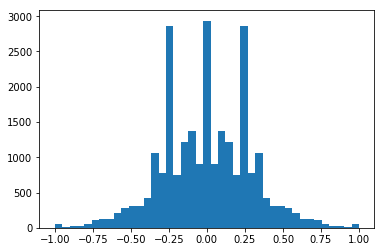

In [9]:
# Plot histogram

print("Number of images: ", len(y_train_raw))

plt.figure()
plt.hist(y_train_raw, bins=41, range=(-1.0, 1.0))
plt.show()


In [30]:
## Plotting function
def plot_imgs(X, y=np.array([]), cols = 6, cmap='brg'):
    
    num_cols = cols
    num_plots = len(X)
    num_rows = int(math.ceil(num_plots/2))
    
    shp = X[0].shape
    
    plotNum = 1
    plt.figure(figsize = (20, num_rows*4))
    for i in range(num_plots):
        
        thisFig = cv2.cvtColor(X[i], cv2.COLOR_YUV2RGB)
        plt.subplot(num_rows, num_cols, plotNum)
        plt.imshow(thisFig, cmap=cmap)
        if(len(y) > 0):
            #Generate a line to plot
            #print(y[i])
            steer_angle = y[i]*25*math.pi/180 #steer value of 1 maps to 25% steering angle
            offst = np.int(math.atan(steer_angle)*shp[0]/2)
            #print(offst)
            xpnts = (math.ceil(shp[1]/2)+offst, shp[1]/2)
            ypnts = (math.ceil(shp[0]/2), shp[0])
            plt.plot(xpnts, ypnts, '-', linewidth=4.0)
        plotNum = plotNum + 1




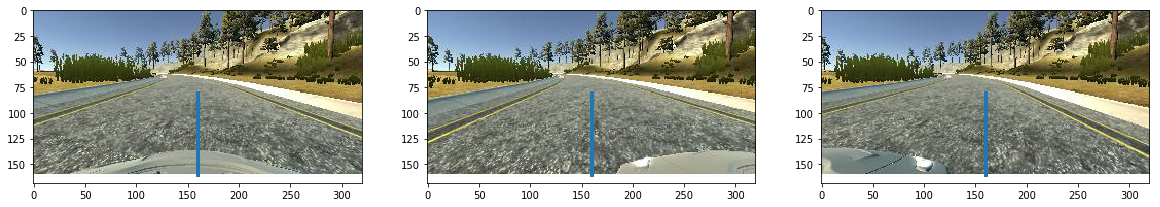

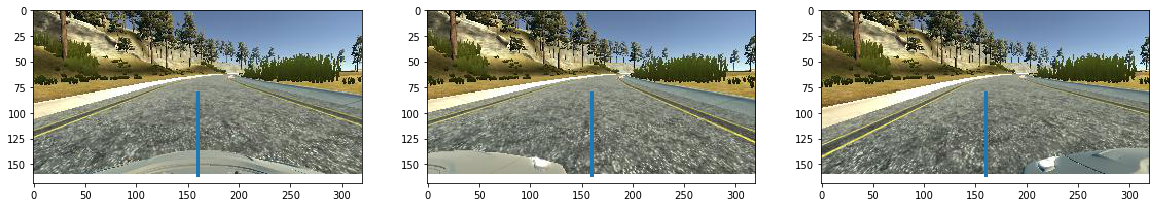

In [37]:
# Plot images with steering correction.

thisImg = 250

thisImg = thisImg*6 #For every center image, there are 6 images - center, center flip, left, left flip, right, right flip
test_imgs = [thisImg, thisImg+2, thisImg+4]
plot_imgs(X_train_raw[test_imgs], y_train_raw[test_imgs], cols=3)

# Plot flipped images with steering correction.
test_imgs = [thisImg+1, thisImg+3, thisImg+5]
plot_imgs(X_train_raw[test_imgs], y_train_raw[test_imgs], cols=3)  

(3656, 160, 320, 3)
(1219, 160, 320, 3)
(24960, 160, 320, 3)
(22523, 160, 320, 3)


<function matplotlib.pyplot.show(*args, **kw)>

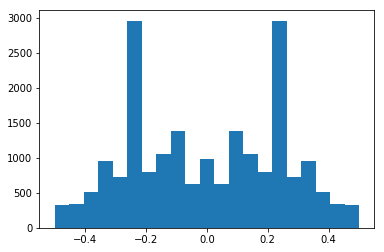

In [35]:
# Filter data - need to move this before data/steering augmentation...
steer_angle_thresh = 0.04
X_train = X_train_raw[(y_train_raw <= -steer_angle_thresh) | (y_train_raw >= steer_angle_thresh)]
y_train = y_train_raw[(y_train_raw <= -steer_angle_thresh) | (y_train_raw >= steer_angle_thresh)]

X_train_straight = X_train_raw[(y_train_raw > -steer_angle_thresh) & (y_train_raw < steer_angle_thresh)]
y_train_straight = y_train_raw[(y_train_raw > -steer_angle_thresh) & (y_train_raw < steer_angle_thresh)]

print (X_train_straight.shape)
# Grab 33% of straight data
X_train_straight = X_train_straight[np.arange(0, len(y_train_straight)-1, 3)]
y_train_straight = y_train_straight[np.arange(0, len(y_train_straight)-1, 3)]

print (X_train_straight.shape)

X_train = np.append(X_train, X_train_straight, axis=0)
y_train = np.append(y_train, y_train_straight, axis=0)

print(X_train_raw.shape)
print(X_train.shape)

plt.figure()
plt.hist(y_train, bins=21, range=(-0.5, 0.5))
plt.show
